In [21]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
import shap
import lime
from lime import lime_tabular
import lightgbm as lgb
import os

# Set random seed for reproducibility
np.random.seed(42)

In [23]:
# Create directory for saving plots
plots_dir = 'plots'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)
    print(f"Created directory: {plots_dir}")

# Set style for all plots
plt.style.use('seaborn')
sns.set_palette("husl")


Created directory: plots


The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [5]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country', 'income']

df = pd.read_csv(url, names=columns, sep=', ', engine='python')

# Clean the data
df = df.replace('?', np.nan)
df = df.dropna()

# Convert target variable to binary
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

# Display basic information
print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (30162, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [6]:
# Separate categorical and numerical features
categorical_features = ['workclass', 'education', 'marital-status', 'occupation',
                       'relationship', 'race', 'sex', 'native-country']
numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain',
                     'capital-loss', 'hours-per-week']

# Encode categorical variables
le = LabelEncoder()
df_encoded = df.copy()
for feature in categorical_features:
    df_encoded[feature] = le.fit_transform(df[feature])

# Scale numerical features
scaler = StandardScaler()
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

# Prepare features and target
X = df_encoded.drop('income', axis=1)
y = df_encoded['income']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [8]:
# Set parameters for GPU training
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'device': 'gpu',  # Use GPU
    'gpu_platform_id': 0,
    'gpu_device_id': 0
}

In [10]:
# Train the model
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

[LightGBM] [Info] Number of positive: 5978, number of negative: 18151
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 24129, number of used features: 14
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (0.28 MB) transferred to GPU in 0.001236 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247752 -> initscore=-1.110640
[LightGBM] [Info] Start training from score -1.110640
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.287471


In [11]:

# Evaluate model performance
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.8700480689540858

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4503
           1       0.79      0.66      0.72      1530

    accuracy                           0.87      6033
   macro avg       0.84      0.80      0.82      6033
weighted avg       0.87      0.87      0.87      6033



# I will implement three different XAI techniques:

### 1. SHAP (SHapley Additive exPlanations)

### 2. LIME (Local Interpretable Model-agnostic Explanations)

### 3. Permutation Importance


#### 1. SHAP Values


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


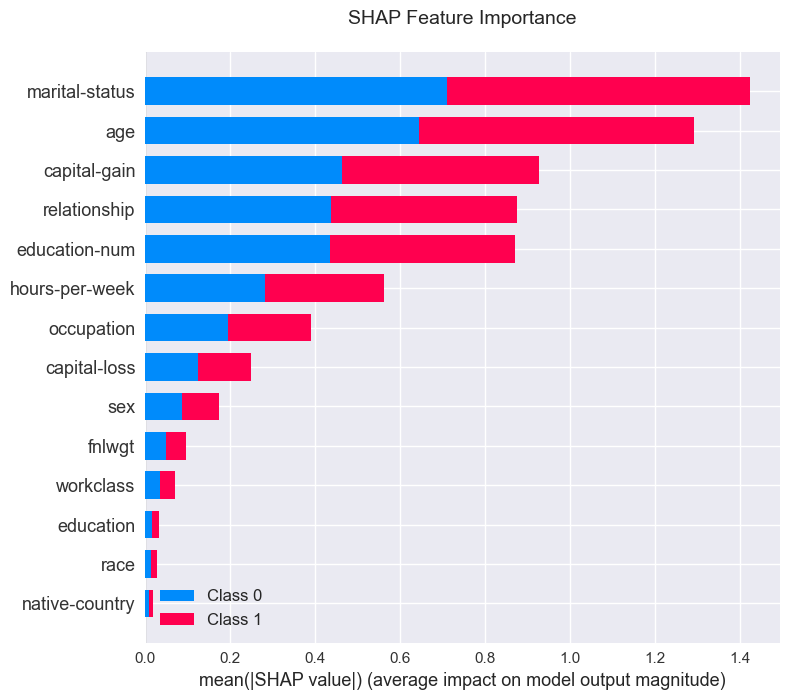

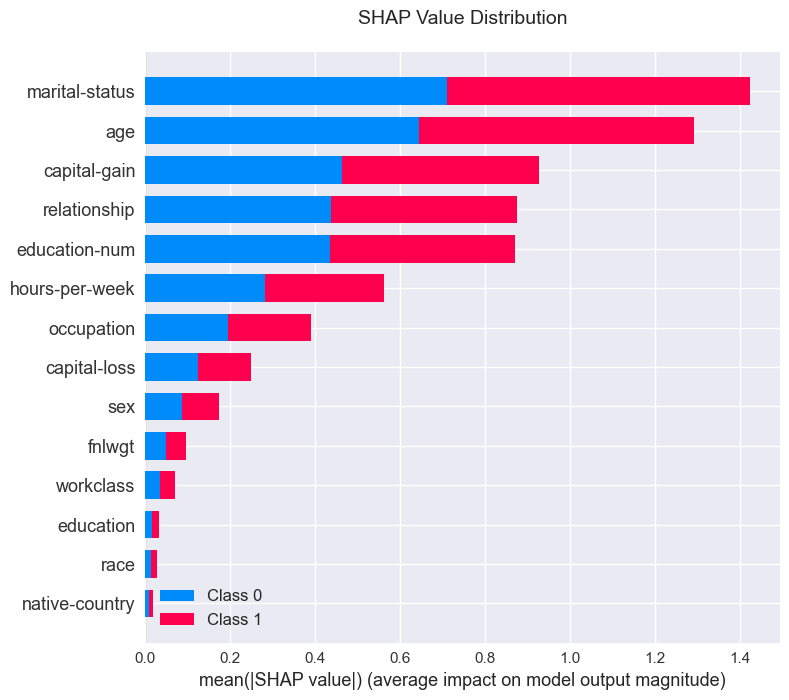

In [27]:
# Calculate SHAP values with GPU support
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Plot detailed SHAP values
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Value Distribution", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

#### 2. LIME Explanations.show_in_notebook()

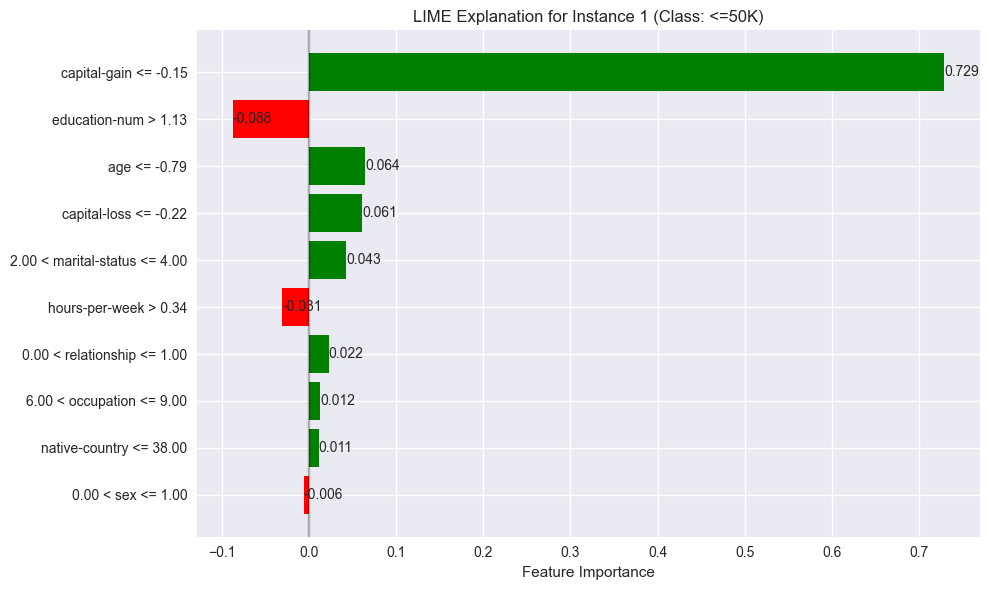

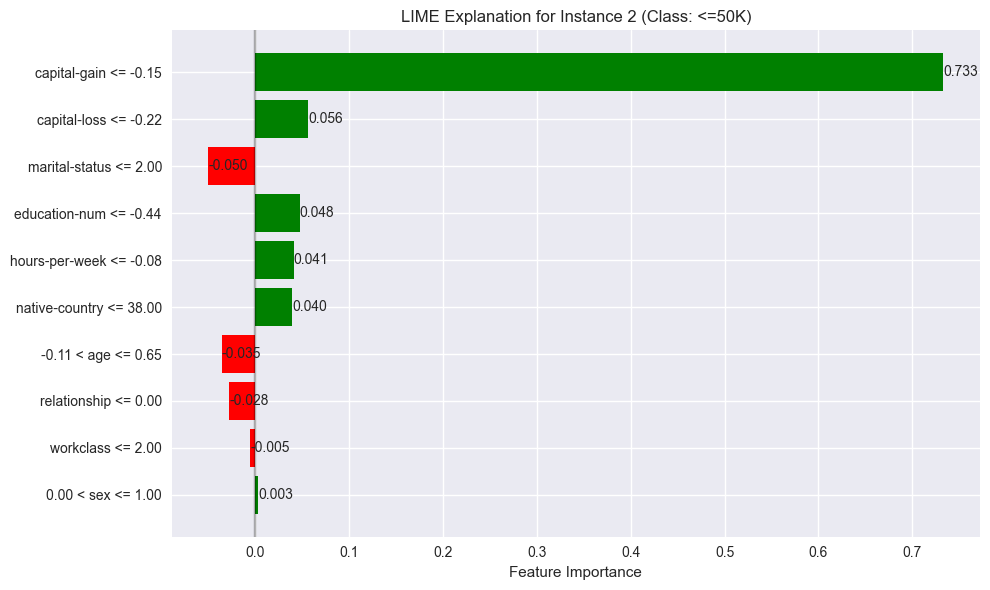

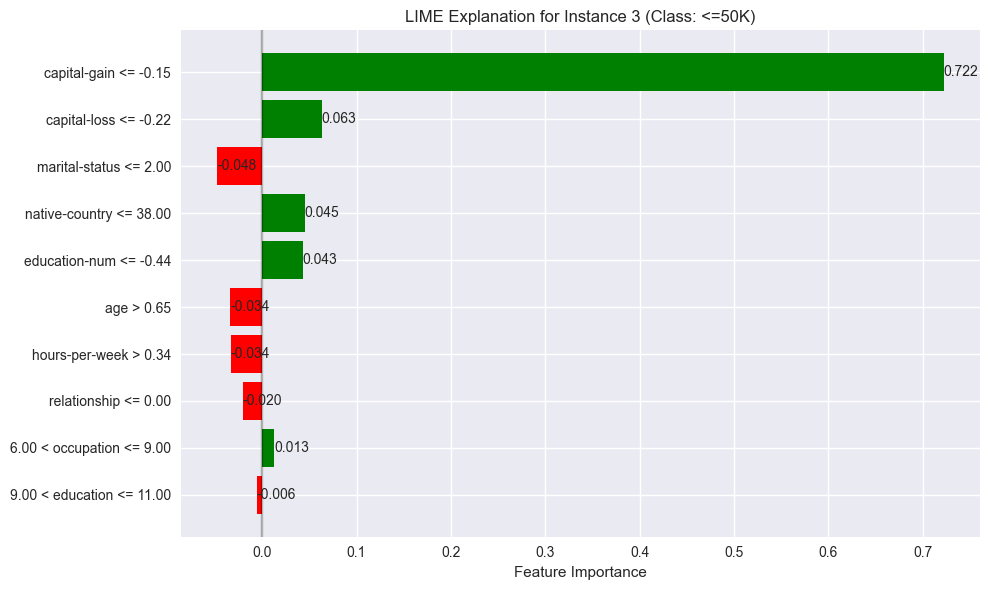

In [25]:
# Create LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['<=50K', '>50K'],
    mode='classification'
)

# Create a prediction function that returns probabilities
def predict_proba(x):
    return np.column_stack((1 - model.predict(x), model.predict(x)))

# Explain a few test instances and display in notebook
for i in range(3):
    exp = explainer.explain_instance(
        X_test.iloc[i].values, 
        predict_proba,
        num_features=10,
        top_labels=1
    )
    
    # Create figure for LIME explanation
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    
    # Get the explanation data for the predicted class
    predicted_class = np.argmax(predict_proba(X_test.iloc[i].values.reshape(1, -1)))
    exp_list = exp.as_list(label=predicted_class)
    features = [x[0] for x in exp_list]
    values = [x[1] for x in exp_list]
    
    # Create horizontal bar plot
    y_pos = np.arange(len(features))
    colors = ['red' if v < 0 else 'green' for v in values]
    ax.barh(y_pos, values, align='center', color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'LIME Explanation for Instance {i+1} (Class: {"<=50K" if predicted_class == 0 else ">50K"})')
    
    # Add value labels
    for j, v in enumerate(values):
        ax.text(v, j, f'{v:.3f}', va='center')
    
    # Add a vertical line at x=0
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

#### 3 Permutation Importance

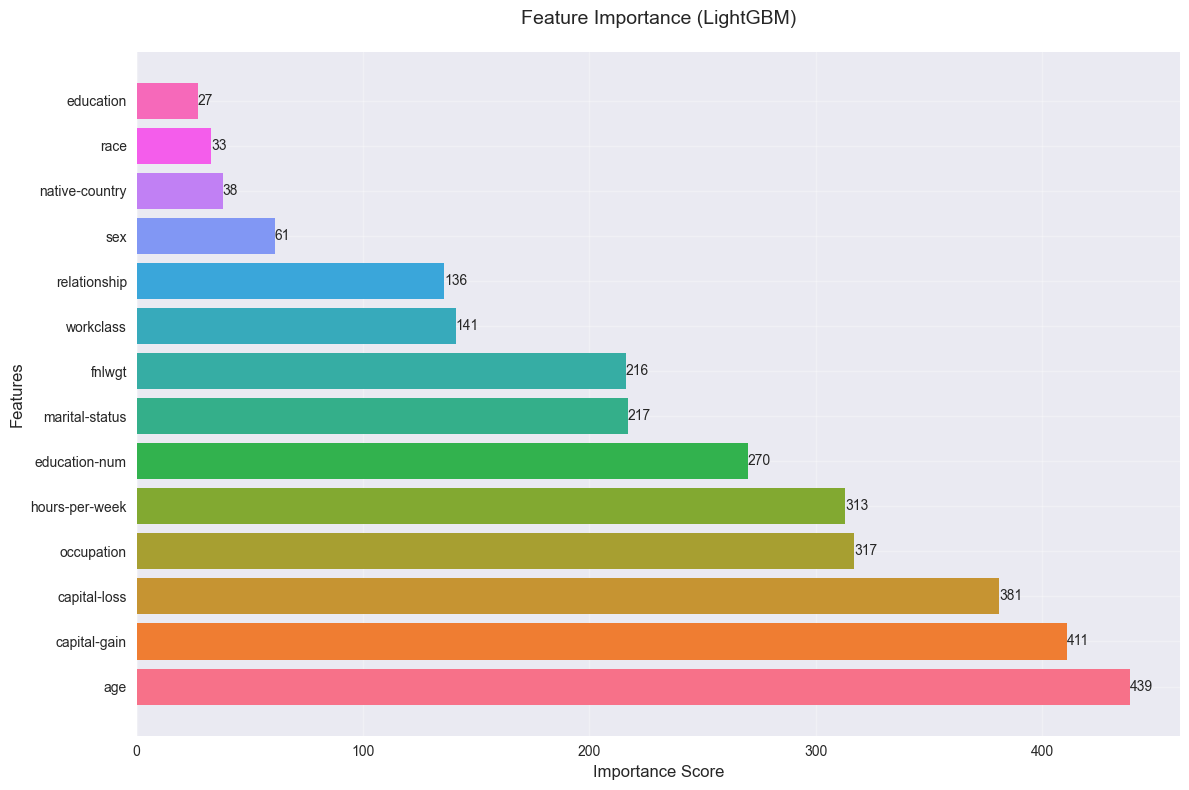


Feature Importance Scores:
           Feature  Importance
0              age         439
10    capital-gain         411
11    capital-loss         381
6       occupation         317
12  hours-per-week         313
4    education-num         270
5   marital-status         217
2           fnlwgt         216
1        workclass         141
7     relationship         136
9              sex          61
13  native-country          38
8             race          33
3        education          27


In [28]:
# Get feature importance from LightGBM
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importance()
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot the results with enhanced styling
plt.figure(figsize=(12, 8))
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'],
                color=sns.color_palette("husl", len(feature_importance)))

# Add value labels on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.0f}', 
             ha='left', va='center', fontsize=10)

plt.title('Feature Importance (LightGBM)', fontsize=14, pad=20)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print the importance scores
print("\nFeature Importance Scores:")
print(feature_importance.sort_values('Importance', ascending=False))

### 4. Additional Visualizations


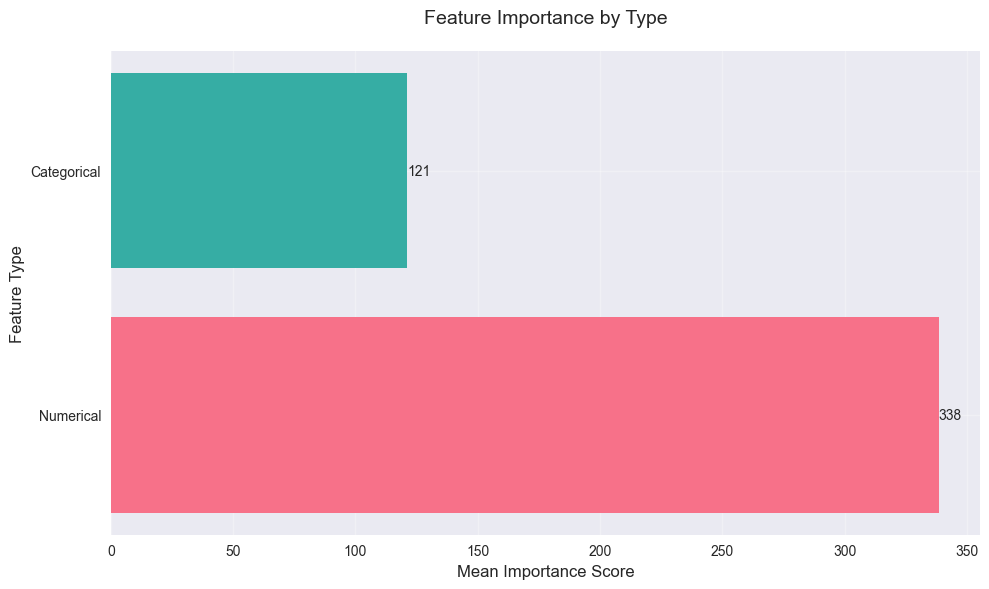


Feature Type Importance Scores:
          Type  Importance
1    Numerical  338.333333
0  Categorical  121.250000


In [29]:

# %%
# Plot feature importance by type (categorical vs numerical)
feature_types = pd.DataFrame({
    'Feature': X_train.columns,
    'Type': ['Categorical' if f in categorical_features else 'Numerical' for f in X_train.columns],
    'Importance': model.feature_importance()
})

# Group by feature type and calculate mean importance
type_importance = feature_types.groupby('Type')['Importance'].mean().reset_index()
type_importance = type_importance.sort_values('Importance', ascending=False)

# Plot feature type importance
plt.figure(figsize=(10, 6))
bars = plt.barh(type_importance['Type'], type_importance['Importance'],
                color=sns.color_palette("husl", len(type_importance)))

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.0f}', 
             ha='left', va='center', fontsize=10)

plt.title('Feature Importance by Type', fontsize=14, pad=20)
plt.xlabel('Mean Importance Score', fontsize=12)
plt.ylabel('Feature Type', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print the type importance scores
print("\nFeature Type Importance Scores:")
print(type_importance.sort_values('Importance', ascending=False))


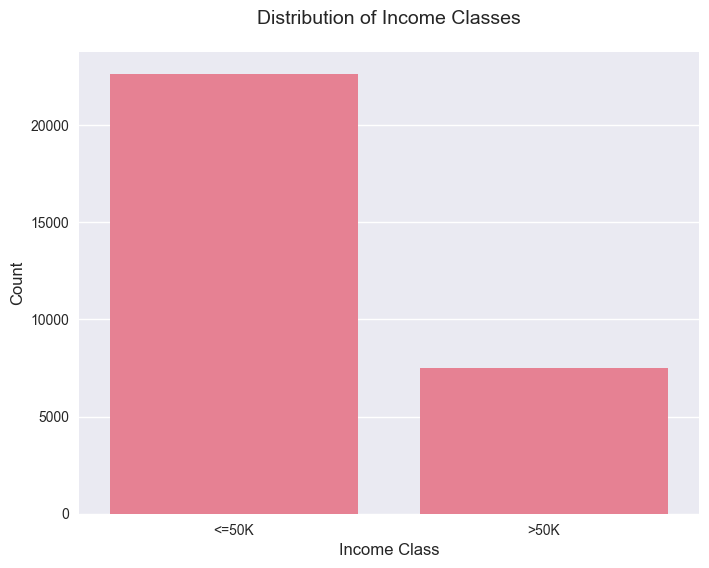

In [31]:
# 1. Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='income')
plt.title('Distribution of Income Classes', fontsize=14, pad=20)
plt.xlabel('Income Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['<=50K', '>50K'])
plt.show()


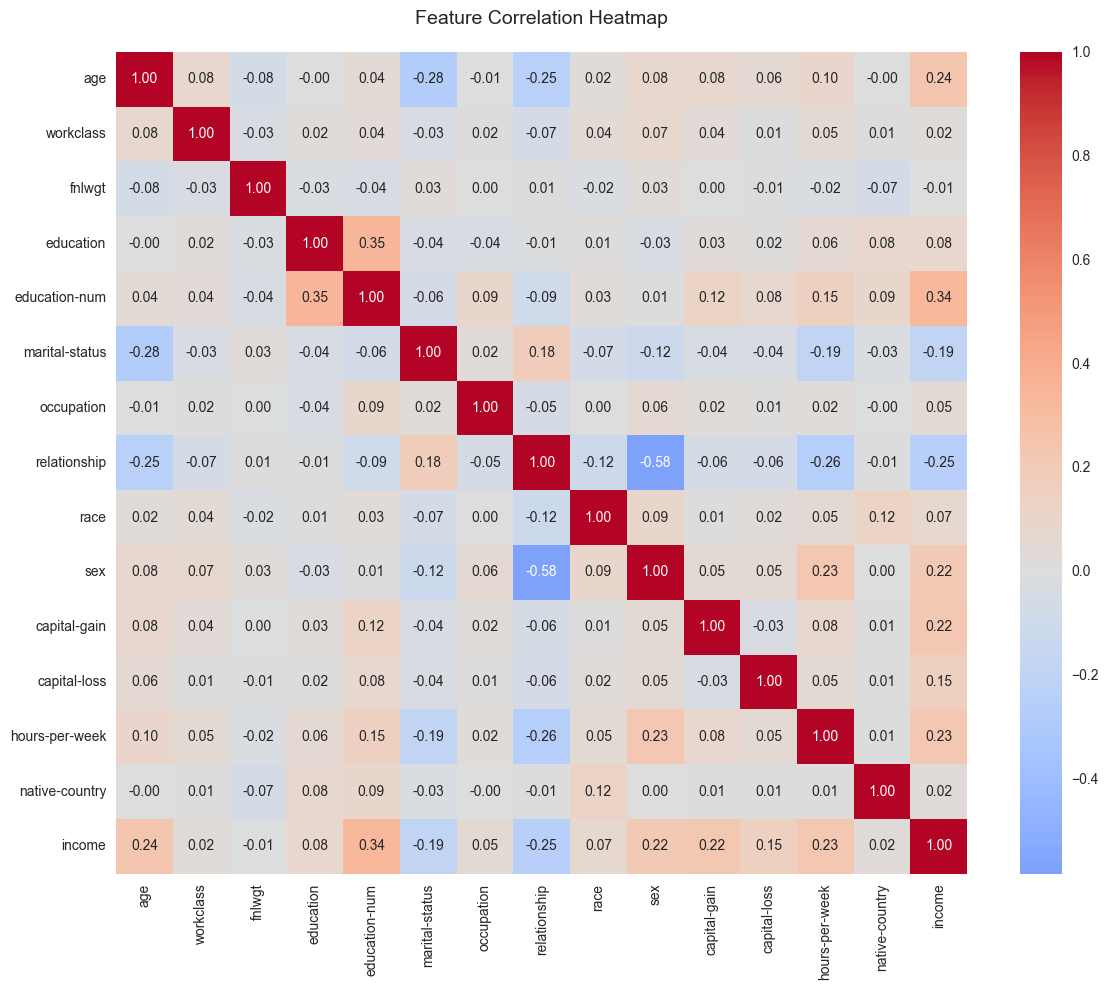

In [32]:
# 2. Correlation Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Heatmap', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

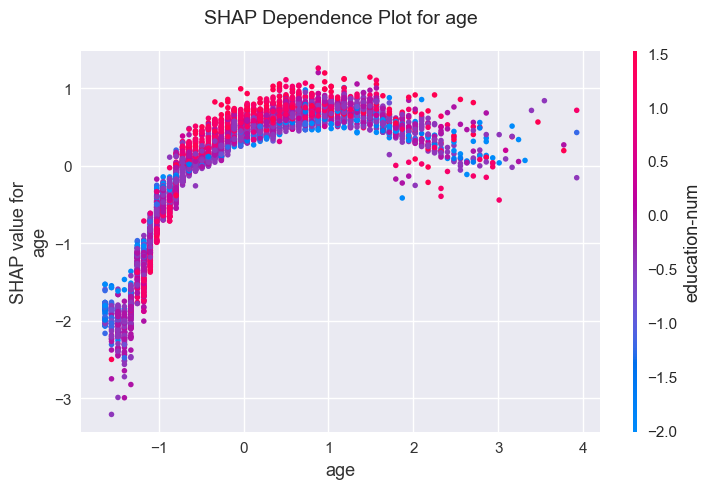

<Figure size 1000x600 with 0 Axes>

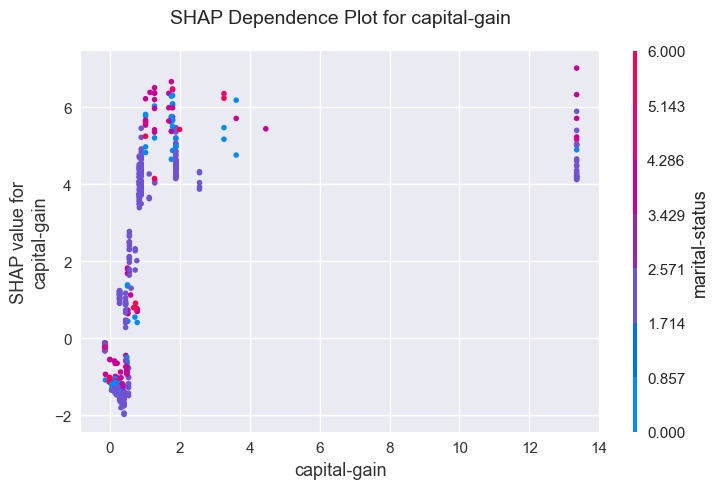

<Figure size 1000x600 with 0 Axes>

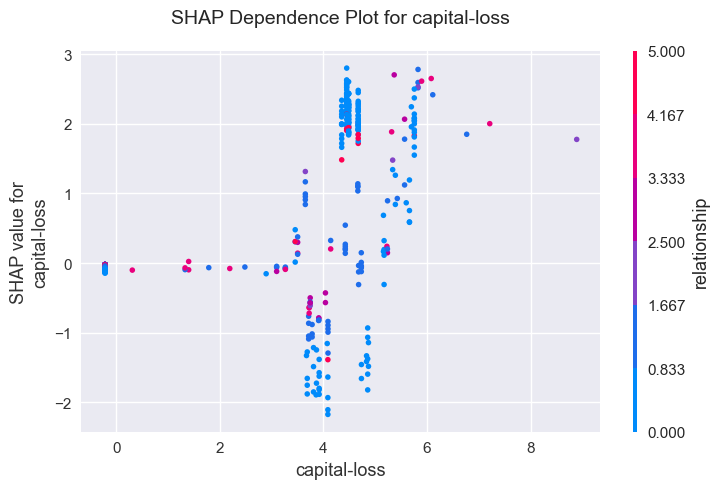

<Figure size 1200x800 with 0 Axes>

In [34]:
# 4. SHAP Dependence Plots for Top Features
top_features = feature_importance['Feature'].head(3).tolist()
for feature in top_features:
    plt.figure(figsize=(10, 6))
    # For binary classification, shap_values[1] contains the SHAP values for the positive class
    shap.dependence_plot(feature, shap_values[1], X_test, show=False)
    plt.title(f'SHAP Dependence Plot for {feature}', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

# 5. Feature Importance Comparison
plt.figure(figsize=(12, 8))
comparison_df = pd.DataFrame({
    'Feature': X_train.columns,
    'LightGBM Importance': model.feature_importance(),
    # For binary classification, use shap_values[1] for the positive class
    'SHAP Importance': np.abs(shap_values[1]).mean(axis=0)
})

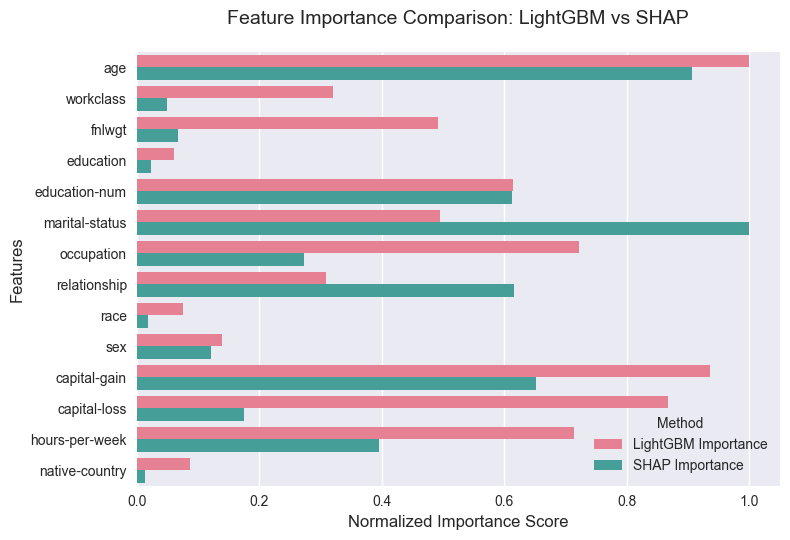

In [36]:
# Normalize the importance scores
comparison_df['LightGBM Importance'] = comparison_df['LightGBM Importance'] / comparison_df['LightGBM Importance'].max()
comparison_df['SHAP Importance'] = comparison_df['SHAP Importance'] / comparison_df['SHAP Importance'].max()

# Melt the dataframe for easier plotting
comparison_df_melted = pd.melt(comparison_df, 
                              id_vars=['Feature'],
                              value_vars=['LightGBM Importance', 'SHAP Importance'],
                              var_name='Method',
                              value_name='Normalized Importance')
# Plot
sns.barplot(data=comparison_df_melted, 
            x='Normalized Importance', 
            y='Feature', 
            hue='Method',
            palette='husl')
plt.title('Feature Importance Comparison: LightGBM vs SHAP', fontsize=14, pad=20)
plt.xlabel('Normalized Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.legend(title='Method')
plt.tight_layout()
plt.show()


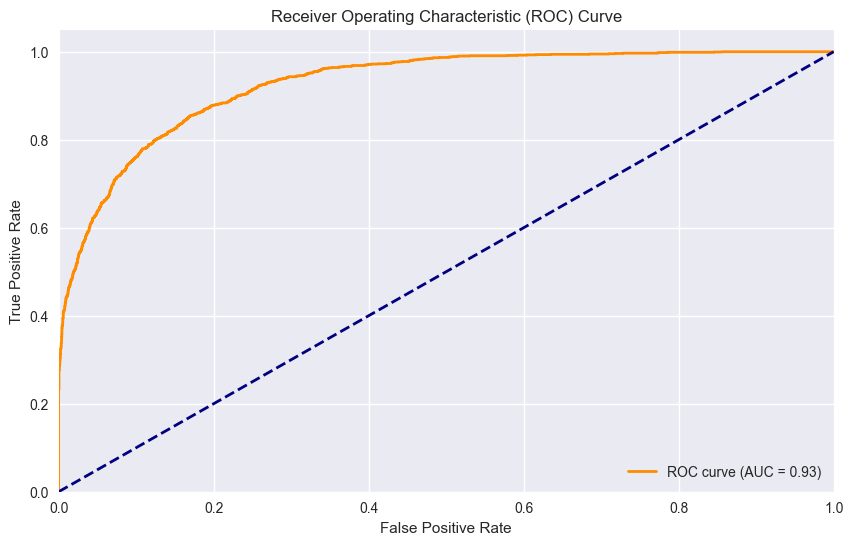

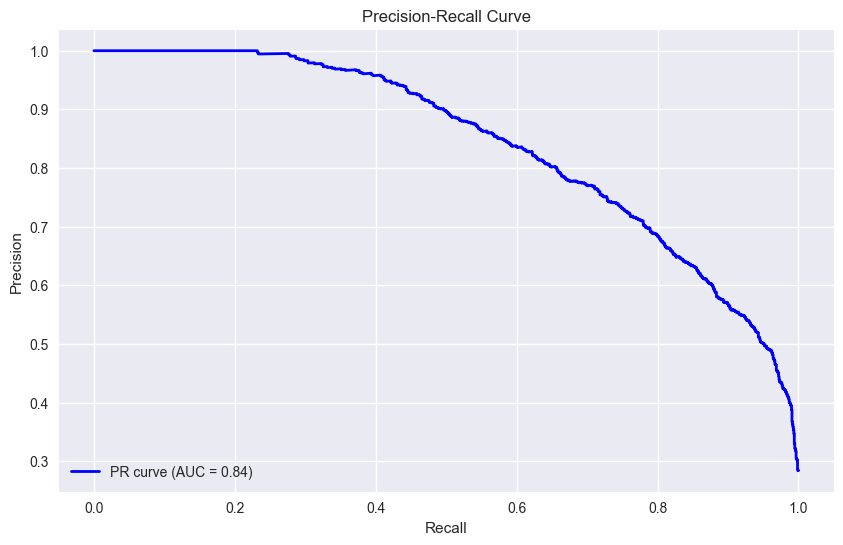

In [37]:
# 6. Model Performance Metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ROC Curve
plt.figure(figsize=(10, 6))
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(10, 6))
precision, recall, _ = precision_recall_curve(y_test, model.predict(X_test))
pr_auc = auc(recall, precision)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()